In [1]:

!pip install matplotlib
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install numpy 


[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu121



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import torchvision.models as models

# Load a pre-trained ResNet-34
resnet18 = models.resnet18(pretrained=True)

# Load an untrained ResNet-34
resnet18_untrained = models.resnet18(pretrained=False)

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

c:\Users\bance\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bance\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\bance\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import roc_auc_score
import numpy as np
import matplotlib.pyplot as plt

In [4]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load the CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)
adversarial_testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


In [5]:
class CNNWith5HiddenLayers(nn.Module):
    def __init__(self):
        super(CNNWith5HiddenLayers, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)     # Hidden layer 1
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)    # Hidden layer 2
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)   # Hidden layer 3
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)  # Hidden layer 4
        self.pool = nn.MaxPool2d(2, 2)                  # Auxiliary layer (Pooling)
        self.fc1 = nn.Linear(256 * 2 * 2, 512)          # Hidden layer 5 (Fully connected)
        self.fc2 = nn.Linear(512, 10)                   # Output layer
        self.relu = nn.ReLU()                           # Activation function
        self.dropout = nn.Dropout(0.5)                  # Auxiliary layer (Dropout)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [7]:
def train_model(model, trainloader, criterion, optimizer, device, epochs=25):
    train_loss = []
    train_accuracy = []

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        for i, (inputs, labels) in enumerate(trainloader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if i % 100 == 99:  # Print every 100 batches
                print(f"Epoch [{epoch+1}/{epochs}], Batch [{i+1}/{len(trainloader)}], Loss: {loss.item():.4f}")

        accuracy = 100 * correct / total
        train_loss.append(running_loss / len(trainloader))
        train_accuracy.append(accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Average Loss: {running_loss/len(trainloader):.4f}, Accuracy: {accuracy:.2f}%")

    return train_loss, train_accuracy


In [8]:
def evaluate_model(model, testloader, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    all_labels = []
    all_outputs = []
    with torch.inference_mode():
        for i, (inputs, labels) in enumerate(testloader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_outputs.extend(torch.nn.functional.softmax(outputs, dim=1).cpu().numpy())

    all_labels = np.array(all_labels)
    all_outputs = np.array(all_outputs)

    # Compute AUC for each class and average them
    auc_scores = []
    for i in range(10):  # Assuming 10 classes for CIFAR-10
        auc = roc_auc_score(all_labels == i, all_outputs[:, i])
        auc_scores.append(auc)

    mean_auc = np.mean(auc_scores)
    accuracy = 100 * correct / total
    print(f"AUC scores for each class: {auc_scores}")
    print(f"Accuracy: {accuracy:.2f}%")
    return mean_auc


In [9]:
model = CNNWith5HiddenLayers().to(device)


# Load the CIFAR-10 dataset

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Train the model
train_loss, train_accuracy = train_model(model, trainloader, criterion, optimizer, device, epochs=25)


Epoch [1/25], Batch [100/500], Loss: 1.8231
Epoch [1/25], Batch [200/500], Loss: 1.6149
Epoch [1/25], Batch [300/500], Loss: 1.5122
Epoch [1/25], Batch [400/500], Loss: 1.1342
Epoch [1/25], Batch [500/500], Loss: 1.3841
Epoch [1/25], Average Loss: 1.6559, Accuracy: 37.92%
Epoch [2/25], Batch [100/500], Loss: 1.0901
Epoch [2/25], Batch [200/500], Loss: 1.2070
Epoch [2/25], Batch [300/500], Loss: 1.0934
Epoch [2/25], Batch [400/500], Loss: 1.1902
Epoch [2/25], Batch [500/500], Loss: 1.1245
Epoch [2/25], Average Loss: 1.1986, Accuracy: 56.73%
Epoch [3/25], Batch [100/500], Loss: 1.0264
Epoch [3/25], Batch [200/500], Loss: 1.1884
Epoch [3/25], Batch [300/500], Loss: 1.0446
Epoch [3/25], Batch [400/500], Loss: 0.8335
Epoch [3/25], Batch [500/500], Loss: 0.9378
Epoch [3/25], Average Loss: 0.9978, Accuracy: 64.64%
Epoch [4/25], Batch [100/500], Loss: 0.7817
Epoch [4/25], Batch [200/500], Loss: 0.8867
Epoch [4/25], Batch [300/500], Loss: 0.8751
Epoch [4/25], Batch [400/500], Loss: 0.8848
Epoch

AUC scores for each class: [0.9739484444444445, 0.9861745, 0.9381387222222223, 0.9105694444444445, 0.9557762222222222, 0.9353716666666667, 0.9733944999999999, 0.9748027777777777, 0.9850548333333333, 0.9795935000000001]
Accuracy: 74.01%
Mean AUC: 0.9612824611111112


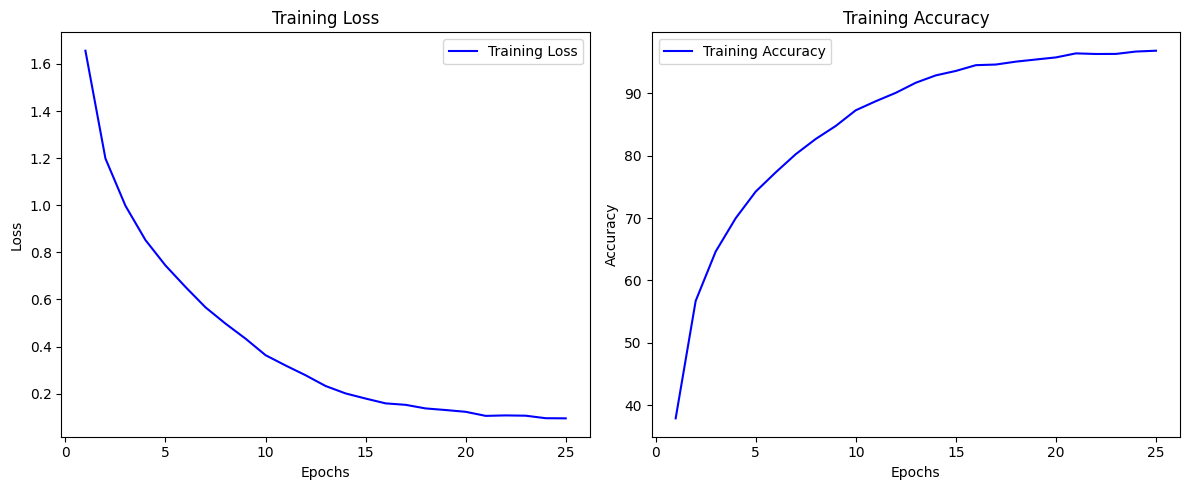

In [10]:
# Evaluate the model
auc = evaluate_model(model, testloader, device)
print(f"Mean AUC: {auc}")

# Plot the training loss and accuracy
epochs = range(1, 26)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, 'b', label='Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [11]:
def fgsm_attack(model, image, label, epsilon):
    # Make sure to set the requires_grad to True so you can get the gradient
    image.requires_grad = True

    # Forward pass the data through the model
    output = model(image)
    loss = torch.nn.functional.cross_entropy(output, label)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect the image gradient
    image_grad = image.grad.data

    # Create the FGSM attack by obtaining the sign of the gradient
    sign_image_grad = image_grad.sign()
    perturbed_image = image + epsilon * sign_image_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

In [12]:
import os
import torch
import torch.nn.functional as F
from torchvision.utils import save_image

# Define the FGSM attack function
def fgsm_attack(model, image, label, epsilon):
    # Set requires_grad attribute of tensor. Important for Attack
    image.requires_grad = True

    # Forward pass the image through the model
    output = model(image)
    loss = criterion(output, label)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect the element-wise sign of the data gradient
    sign_data_grad = image.grad.data.sign()

    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon * sign_data_grad

    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)

    return perturbed_image

# Load a sample image from the test dataset
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Use the first image in the batch for the attack
image = images[0].unsqueeze(0)
label = labels[0].unsqueeze(0)

# Define epsilon values for the FGSM attack
epsilons = [0.001, 0.002, 0.005]

# Create a directory to save the perturbed images if it doesn't exist
os.makedirs('perturbed', exist_ok=True)

# Apply the FGSM attack for each epsilon and save the perturbed image
for epsilon in epsilons:
    perturbed_image = fgsm_attack(model, image, label, epsilon)
    filename = f'perturbed/perturbed_image_epsilon_{epsilon}.png'
    save_image(perturbed_image, filename)
    print(f"Perturbed image with epsilon {epsilon} saved in '{filename}'")

print("All perturbed images saved.")
#Save also the mask

Perturbed image with epsilon 0.001 saved in 'perturbed/perturbed_image_epsilon_0.001.png'
Perturbed image with epsilon 0.002 saved in 'perturbed/perturbed_image_epsilon_0.002.png'
Perturbed image with epsilon 0.005 saved in 'perturbed/perturbed_image_epsilon_0.005.png'
All perturbed images saved.


In [13]:
from PIL import Image


image = Image.open('./perturbed/perturbed_image_epsilon_0.001.png')
new_image = image.resize((500, 500))
new_image.save('myimage_500.jpg')

In [14]:
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

def get_mask(image,perturbed_image):
  return perturbed_image - image

# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [15]:
import os
# from minio import Minio
# from minio.error import S3Error

# minio_client = Minio("localhost:9000",
#         access_key="N18PI0XRzRbLKB8il7Uk",
#         secret_key="8EdhMimLnfe4mYVVYw3BVWPgP7Z5jVagoz79LqEs",
#         secure=False
#     )

# def save_and_upload(data_tensor, filename, bucket_name):
#     # Convert tensor to PIL Image
#     image = transforms.ToPILImage()(data_tensor)
#     img_byte_arr = io.BytesIO()
#     image.save(img_byte_arr, format='PNG')
#     img_byte_arr = img_byte_arr.getvalue()

#     try:
#         minio_client.put_object(
#             bucket_name,
#             filename,
#             io.BytesIO(img_byte_arr),
#             len(img_byte_arr),
#             content_type='image/png'
#         )
#         print(f"Uploaded {filename} successfully.")
#     except S3Error as e:
#         print(f"Failed to upload {filename}: {e}")


def test( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, don't bother attacking, just move on
        if init_pred.item() != target.item():
            image_denorm = denorm(data)
            # Implement the saving function here, for example:
            torch.save(image_denorm, f'./perturbed/init_pred_{init_pred.item()}_target_{target.item()}.pt')

            # in loc de continue,save image init pred.item.target,target
            # target.item este pentru a nu imi da tensor


        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect ``datagrad``
        data_grad = data.grad.data

        # Restore the data to its original scale
        data_denorm = denorm(data)

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data_denorm, epsilon, data_grad)


        # Reapply normalization
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)

        #Test regarding perturbed_data_normalized. scoate ulterior

        #save the mask and the perturbed data normalize

        # Re-classify the perturbed image
        output = model(perturbed_data_normalized)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        #salveaza final_pred si target
        #pt sql imi trebuie de salvat pe hard path,imaginile si epsilon(doar daca se perturbeaza)

    #streamlit sa aiba un input pentru epsilon


In [16]:
test( model, device, adversarial_testloader, epsilon=0.001 )

In [26]:
scripted_model = torch.jit.script(model)

# Save the scripted model
torch.jit.save(scripted_model, 'scripted_cnn_model.pth')

CNNWith5HiddenLayers(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [25]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

def load_model(model_path, is_whole_model=True):
    if is_whole_model:
        model = torch.load(model_path)
    
    model.eval()
    return model
def load_dataset(dataset_path, batch_size=4):
    transform = transforms.Compose([
        transforms.Resize((32, 32)),
        transforms.ToTensor(),
        transforms.Normalize((0.507, 0.487, 0.441), (0.267, 0.256, 0.276))  # CIFAR-100 normalization
    ])
    dataset = datasets.CIFAR100(root=dataset_path, train=False, download=True, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def evaluate_model(model, dataloader, device='cpu'):
    model.to(device)
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the model on the dataset: {accuracy:.2f}%')

if __name__ == "__main__":
    model_path = 'full_model.pth'  # or 'model_state_dict.pth'
    is_whole_model = True  # Change this based on how you saved your model
    dataset_path = './data'  # Local path for downloading/storing CIFAR-100

    model = load_model(model_path, is_whole_model=is_whole_model)
    dataloader = load_dataset(dataset_path)
    evaluate_model(model, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu')

100%|██████████| 169001437/169001437 [00:19<00:00, 8783450.96it/s] 


Extracting ./data\cifar-100-python.tar.gz to ./data
Accuracy of the model on the dataset: 1.10%
